In [1]:
import torch
import torchvision.datasets
import torchvision.models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm
from train_utils import get_data_loaders, train, test
from PIL import Image
import pandas as pd

In [2]:
root = './distilled_dataset'

### CIFAR10 Distilled

In [3]:
class CIFAR10_Distilled(Dataset):
    def __init__(self, idx_df, transform):
        self.idx_df = idx_df
        self.transform = transform
    
    def __len__(self):
        return len(self.idx_df)

    def __getitem__(self, index):
        entry = self.idx_df.iloc[index]
        image = self.transform(Image.open(entry.image_path))
        label = entry.label
        return image, torch.tensor(label)

In [4]:
index_file = pd.read_csv('./CIFAR10_DM_index_files/ipc500_idx.csv')
index_file

,image_path,label
0,./CIFAR10_DM/ipc500/airplane/003746e7-c915-4d7...,0
1,./CIFAR10_DM/ipc500/airplane/0090a052-69a0-461...,0
2,./CIFAR10_DM/ipc500/airplane/0143960d-3978-448...,0
3,./CIFAR10_DM/ipc500/airplane/01ee79d8-a8fe-430...,0
4,./CIFAR10_DM/ipc500/airplane/0231edfd-42fd-477...,0
...,...,...
4995,./CIFAR10_DM/ipc500/truck/fb1fbeaf-b6c7-4da4-a...,9
4996,./CIFAR10_DM/ipc500/truck/fcd9e0b0-9b62-4d41-8...,9
4997,./CIFAR10_DM/ipc500/truck/fdefdd6d-2fd9-42f1-b...,9
4998,./CIFAR10_DM/ipc500/truck/ff83d309-da9a-459a-a...,9


In [5]:
image_normalize= transforms.Lambda(lambda img: 2 * img / 255. - 1) # normalize to [-1, 1]
# https://github.com/Lornatang/pytorch-alexnet-cifar100/blob/master/utils/datasets.py
transform = transforms.Compose([
                                transforms.Resize(64),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                # image_normalize
                              ])
cifar10_distilled_train = CIFAR10_Distilled(index_file, transform)

cifar10_root = '../cifar10'
cifar10_test = torchvision.datasets.CIFAR10(cifar10_root,
                                            train=False,
                                            transform=transforms.Compose([
                                                transforms.Resize(64),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                                # image_normalize
                                              ]))

In [6]:
batch_size = 32 # cut batch size to half for ipc50
train_data_loader, test_data_loader = get_data_loaders(cifar10_distilled_train, cifar10_test, batch_size=batch_size)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

[INFO]: Computation device: cuda


In [8]:
model_name = 'alexnet'
dataset = 'cifar10_distilled'
model_path = f'./model_weight/{dataset}/{model_name}/'
model = torchvision.models.alexnet(num_classes=10).to(device)

In [9]:
train_record, test_record  = train(model, model_path, train_data_loader, test_data_loader)

Epoch 1: 100%|██████████| 157/157 [00:06<00:00, 23.52it/s, loss=2.3] 


epoch: 1 done, loss: 0.07228633016347885
Acc: 0.1318


Epoch 2: 100%|██████████| 157/157 [00:03<00:00, 45.05it/s, loss=2.3] 


epoch: 2 done, loss: 0.07223151624202728
Acc: 0.1053


Epoch 3: 100%|██████████| 157/157 [00:03<00:00, 44.25it/s, loss=2.25]


epoch: 3 done, loss: 0.07202731817960739
Acc: 0.1


Epoch 4: 100%|██████████| 157/157 [00:03<00:00, 39.25it/s, loss=2.14]


epoch: 4 done, loss: 0.07038047164678574
Acc: 0.1428


Epoch 5: 100%|██████████| 157/157 [00:04<00:00, 35.82it/s, loss=1.99]


epoch: 5 done, loss: 0.06477852910757065
Acc: 0.1813


Epoch 6: 100%|██████████| 157/157 [00:04<00:00, 37.63it/s, loss=1.94]


epoch: 6 done, loss: 0.05504429712891579
Acc: 0.2063


Epoch 7: 100%|██████████| 157/157 [00:04<00:00, 35.85it/s, loss=1.74]


epoch: 7 done, loss: 0.04624943062663078
Acc: 0.1648


Epoch 8: 100%|██████████| 157/157 [00:03<00:00, 42.28it/s, loss=1.35] 


epoch: 8 done, loss: 0.041093096137046814
Acc: 0.2088


Epoch 9: 100%|██████████| 157/157 [00:03<00:00, 44.12it/s, loss=0.978]


epoch: 9 done, loss: 0.03625559061765671
Acc: 0.2895


Epoch 10: 100%|██████████| 157/157 [00:03<00:00, 43.95it/s, loss=1.46] 


epoch: 10 done, loss: 0.03199277073144913
Acc: 0.3566


Epoch 11: 100%|██████████| 157/157 [00:03<00:00, 44.03it/s, loss=0.545]


epoch: 11 done, loss: 0.028468215838074684
Acc: 0.3796


Epoch 12: 100%|██████████| 157/157 [00:03<00:00, 43.82it/s, loss=0.853]


epoch: 12 done, loss: 0.024695150554180145
Acc: 0.2149


Epoch 13: 100%|██████████| 157/157 [00:03<00:00, 44.67it/s, loss=0.818]


epoch: 13 done, loss: 0.023011520504951477
Acc: 0.3334


Epoch 14: 100%|██████████| 157/157 [00:03<00:00, 44.57it/s, loss=0.326]


epoch: 14 done, loss: 0.020207297056913376
Acc: 0.3873


Epoch 15: 100%|██████████| 157/157 [00:03<00:00, 45.36it/s, loss=0.285]


epoch: 15 done, loss: 0.017619267106056213
Acc: 0.3954


Epoch 16: 100%|██████████| 157/157 [00:03<00:00, 45.13it/s, loss=0.347]


epoch: 16 done, loss: 0.015716644003987312
Acc: 0.4139


Epoch 17: 100%|██████████| 157/157 [00:03<00:00, 43.96it/s, loss=0.461]


epoch: 17 done, loss: 0.013850504532456398
Acc: 0.4187


Epoch 18: 100%|██████████| 157/157 [00:03<00:00, 43.94it/s, loss=0.562]


epoch: 18 done, loss: 0.013270113617181778
Acc: 0.4523


Epoch 19: 100%|██████████| 157/157 [00:03<00:00, 49.33it/s, loss=0.319]


epoch: 19 done, loss: 0.01094349380582571
Acc: 0.434


Epoch 20: 100%|██████████| 157/157 [00:03<00:00, 45.42it/s, loss=0.38]  


epoch: 20 done, loss: 0.01039381604641676
Acc: 0.3701


Epoch 21: 100%|██████████| 157/157 [00:03<00:00, 45.07it/s, loss=0.383] 


epoch: 21 done, loss: 0.008928993716835976
Acc: 0.3786


Epoch 22: 100%|██████████| 157/157 [00:03<00:00, 44.34it/s, loss=0.172] 


epoch: 22 done, loss: 0.009486722759902477
Acc: 0.4422


Epoch 23: 100%|██████████| 157/157 [00:03<00:00, 44.31it/s, loss=1.5]   


epoch: 23 done, loss: 0.008166683837771416
Acc: 0.267


Epoch 24: 100%|██████████| 157/157 [00:03<00:00, 44.16it/s, loss=0.852] 


epoch: 24 done, loss: 0.007572021335363388
Acc: 0.4039


Epoch 25: 100%|██████████| 157/157 [00:03<00:00, 44.01it/s, loss=0.193] 


epoch: 25 done, loss: 0.006772798951715231
Acc: 0.3465


Epoch 26: 100%|██████████| 157/157 [00:03<00:00, 44.21it/s, loss=0.0693]


epoch: 26 done, loss: 0.006580112501978874
Acc: 0.4968


Epoch 27: 100%|██████████| 157/157 [00:03<00:00, 44.42it/s, loss=0.00904]


epoch: 27 done, loss: 0.0053164344280958176
Acc: 0.4958


Epoch 28: 100%|██████████| 157/157 [00:03<00:00, 44.46it/s, loss=0.00623]


epoch: 28 done, loss: 0.004931953269988298
Acc: 0.4885


Epoch 29: 100%|██████████| 157/157 [00:03<00:00, 45.05it/s, loss=0.028] 


epoch: 29 done, loss: 0.00432661222293973
Acc: 0.4996


Epoch 30: 100%|██████████| 157/157 [00:03<00:00, 44.45it/s, loss=0.0145]


epoch: 30 done, loss: 0.004984191618859768
Acc: 0.5054


Epoch 31: 100%|██████████| 157/157 [00:03<00:00, 44.19it/s, loss=0.125]  


epoch: 31 done, loss: 0.0035906238481402397
Acc: 0.5106


Epoch 32: 100%|██████████| 157/157 [00:03<00:00, 43.99it/s, loss=0.0133]


epoch: 32 done, loss: 0.003274130169302225
Acc: 0.5042


Epoch 33: 100%|██████████| 157/157 [00:03<00:00, 44.40it/s, loss=0.037]  


epoch: 33 done, loss: 0.0027274040039628744
Acc: 0.5115


Epoch 34: 100%|██████████| 157/157 [00:03<00:00, 43.90it/s, loss=0.0741] 


epoch: 34 done, loss: 0.0035096039064228535
Acc: 0.504


Epoch 35: 100%|██████████| 157/157 [00:03<00:00, 44.15it/s, loss=0.00332]


epoch: 35 done, loss: 0.0025603240355849266
Acc: 0.5228


Epoch 36: 100%|██████████| 157/157 [00:03<00:00, 43.99it/s, loss=0.0212] 


epoch: 36 done, loss: 0.0022925203666090965
Acc: 0.5156


Epoch 37: 100%|██████████| 157/157 [00:03<00:00, 44.45it/s, loss=0.00563]


epoch: 37 done, loss: 0.001964692724868655
Acc: 0.5276


Epoch 38: 100%|██████████| 157/157 [00:03<00:00, 44.44it/s, loss=0.0123] 


epoch: 38 done, loss: 0.002244409639388323
Acc: 0.515


Epoch 39: 100%|██████████| 157/157 [00:03<00:00, 50.06it/s, loss=0.0256] 


epoch: 39 done, loss: 0.0014578151749446988
Acc: 0.4922


Epoch 40: 100%|██████████| 157/157 [00:03<00:00, 44.86it/s, loss=0.0063]  


epoch: 40 done, loss: 0.001697623752988875
Acc: 0.4928


Epoch 41: 100%|██████████| 157/157 [00:03<00:00, 44.12it/s, loss=0.0189] 


epoch: 41 done, loss: 0.001232221256941557
Acc: 0.5206


Epoch 42: 100%|██████████| 157/157 [00:03<00:00, 44.44it/s, loss=0.000818]


epoch: 42 done, loss: 0.0017399137141183019
Acc: 0.5233


Epoch 43: 100%|██████████| 157/157 [00:03<00:00, 44.18it/s, loss=0.000166]


epoch: 43 done, loss: 0.0011114717926830053
Acc: 0.5278


Epoch 44: 100%|██████████| 157/157 [00:03<00:00, 43.93it/s, loss=0.000764]


epoch: 44 done, loss: 0.0007272896473295987
Acc: 0.524


Epoch 45: 100%|██████████| 157/157 [00:03<00:00, 44.38it/s, loss=0.092]  


epoch: 45 done, loss: 0.002605719957500696
Acc: 0.5109


Epoch 46: 100%|██████████| 157/157 [00:03<00:00, 44.63it/s, loss=0.00898]


epoch: 46 done, loss: 0.001127823255956173
Acc: 0.521


Epoch 47: 100%|██████████| 157/157 [00:03<00:00, 44.82it/s, loss=0.00117] 


epoch: 47 done, loss: 0.0007808408117853105
Acc: 0.5313


Epoch 48: 100%|██████████| 157/157 [00:03<00:00, 44.62it/s, loss=0.0218] 


epoch: 48 done, loss: 0.0012854881351813674
Acc: 0.5226


Epoch 49: 100%|██████████| 157/157 [00:03<00:00, 44.64it/s, loss=0.000429]


epoch: 49 done, loss: 0.00037164363311603665
Acc: 0.5226


Epoch 50: 100%|██████████| 157/157 [00:03<00:00, 44.70it/s, loss=0.0132]  


epoch: 50 done, loss: 0.0025907219387590885
Acc: 0.5097
Time taken: 313.134359 seconds


In [31]:
test(model, f'{model_path}/model.bin', test_data_loader, criterion=nn.CrossEntropyLoss()) #best_acc, test_loss

(0.5313, tensor(0.0955, device='cuda:0'))

<AxesSubplot: >

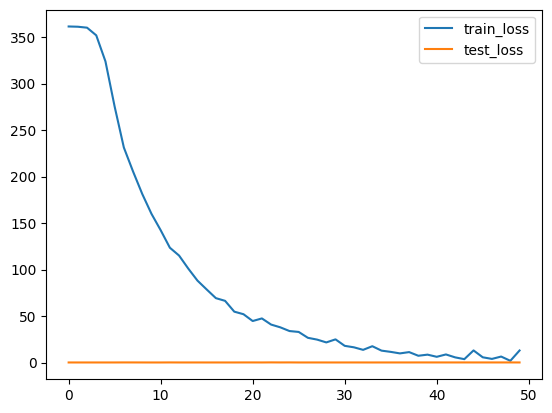

In [27]:
import pandas as pd
results = pd.DataFrame([])
results['train_loss']  = train_record
results['test_loss']  = test_record
results.plot.line(y=['train_loss', 'test_loss'])